# Gas Door: Position detection 

In [278]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.cluster import DBSCAN
import base64
import pdb


from itertools import zip_longest, product, chain
import random
from pathlib import Path
import torch
import torch.nn as nn
from torchvision.transforms.functional import (pad, to_tensor, to_pil_image, normalize,
                                               hflip, vflip, crop)

torch.manual_seed(0);

from PIL import Image
from IPython.display import display

In [170]:
from torchvision import models
import torch.nn as nn


def make_decoder_block(in_channels, middle_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(
            middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            encoder = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
        else:
            encoder = models.vgg16_bn(weights=None).features

        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256))

        self.dec5 = make_decoder_block(256 + 512, 512, 256)
        self.dec4 = make_decoder_block(256 + 512, 512, 256)
        self.dec3 = make_decoder_block(256 + 256, 256, 64)
        self.dec2 = make_decoder_block(64 + 128, 128, 32)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(conv5)

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        return self.final(dec1)

In [452]:
def is_cuda_numpy(image):
    if image.is_cuda:
        return image.detach().cpu().numpy()
    return image.detach().numpy()            

def tensor_to_pil(image):
    if isinstance(image, torch.Tensor):
        image = is_cuda_numpy(image)
        return Image.fromarray(image.astype(np.uint8)) 
    return image

    
def calculate_bboxes(im_shape, patch_size):
    h, w = im_shape  # 640,1080
    ph, pw = patch_size  # 256,256
    # range(0, h - ph, ph)=0부터 1080-256=824까지 256간격으로 값 생성
    steps_h = chain(range(0, h - ph, ph), [h - ph]) 
    steps_w = chain(range(0, w - pw, pw), [w - pw])

    return product(steps_h, steps_w)


class Image2Patches():
    '''큰 이미지 받아 작은 여러개의 patch로 분할해 줌'''
    def __init__(self, image_size = (640,1080), patch_size=(256, 256), padding=16):
        self.image_size = image_size
        self.patch_size = patch_size
        self.padding = padding
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)

        h, w = self.image_size
        bboxes = calculate_bboxes((h, w), self.patch_size)
        self.coords = list(zip_longest([], bboxes, fillvalue=0))
        print(self.coords)
        
    def __call__(self, image):
        image  = tensor_to_pil(image)        
        patches = []
        org_image = image.copy()
        h, w = self.patch_size_expanded   
        for idx in range(len(self.coords)):
            _, (i, j) = self.coords[idx]   
            cell = pad(org_image, self.padding, padding_mode='reflect')
            cell = crop(cell, i, j, h, w)
            cell = to_tensor(cell)  
            cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            patches.append((cell, (i,j)))

        return patches

def hough_to_xy(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))  # c
    y1 = int(y0 + 1000 * (a))  # r
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    
    return x1,y1,x2,y2

def strength_line3(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    x1, y1, x2, y2 = hough_to_xy(rho, theta)
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)

    # 선 위의 모든 픽셀 좌표 계산
    all_line_pixels = []
    for t in np.linspace(0, 1, max(abs(x2 - x1), abs(y2 - y1))):
        x = int(x1 * (1 - t) + x2 * t)  # c
        y = int(y1 * (1 - t) + y2 * t)  # r
        if 0 < x < imsize[1] and 0 < y < imsize[0]:
            all_line_pixels.append((x, y))  #(c,r)
            
    total_sum = sum(mask_im[r,c] for c,r in all_line_pixels)/len(all_line_pixels)  # mask[r,c]
    
    return image, total_sum, all_line_pixels


def write_lines(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    x1, y1, x2, y2 = hough_to_xy(rho, theta)
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)
    
    return image

    
def convert_cell_to_pil(t, padding=16):
    """정규화된 tensor이미지를 원 이미지(PIL)로 복원"""
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
    mu = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    output = t.mul(std)
    output.add_(mu)
    img = to_pil_image(output)
    w, h = img.size
    return img.crop((padding, padding, w - padding, h - padding))
    
    
def points_on_line2(org_img, pred_mask, mask_thres=150, \
                   wsize=5, sigma=1.4, low_thres=30, high_thres=80, min_length=50):
    org_img  = tensor_to_pil(org_img)
    image = np.array(org_img)
    
    # 가우시안 블러를 사용하여 노이즈 감소
    blurred_image = cv2.GaussianBlur(image, (wsize, wsize), sigma)
    # Canny 에지 검출
    edges = cv2.Canny(blurred_image, low_thres, high_thres)

    result_image = np.where(pred_mask >= mask_thres, edges, 0)  
    lines = cv2.HoughLines(result_image, 1, np.pi / 180, min_length)
    
    all_lines = []
    if lines.any():
        for (rho,theta) in lines[:,0]:
            if rho<0: #### theta is in RADIAN(not DEG)
                rho = -rho
                theta = theta+np.pi
            all_lines.append((rho,theta))    
    return np.array(all_lines)


def dbscan_line(data, eps=10, min_samples=2):
    indexes, labels, unique_labels = [], [], []
    if data.any():
        rho, theta_deg = data[:, 0], data[:,1]
        theta_rad = np.deg2rad(theta_deg)

        # 새로운 데이터셋 (rho, sin(theta), cos(theta))
        sin_theta = np.sin(theta_rad)
        cos_theta = np.cos(theta_rad)
        transformed_data = np.column_stack((rho, sin_theta, cos_theta))

        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(transformed_data)

        labels = dbscan.labels_
        unique_labels = set(labels)
        indexes = [np.where(labels == ind)[0] for ind in unique_labels]
    
    return indexes, labels, unique_labels
    

def best_hough(data, indexes, image, mask, imsize):
    image  = tensor_to_pil(image)        
    best_lines = []
    for indx in indexes:
        votes = []
        for idx, (rho, theta) in enumerate(data[indx]):
            img = np.array(image.copy())
            res_im, psum, all_line_pixels = strength_line3(img, mask, rho, theta, imsize=imsize)
            votes.append((res_im, psum, all_line_pixels, (rho,theta)))

        max_element = max(votes, key=lambda x: x[1])    
        best_lines.append(max_element)
        
    return best_lines


def not_localhost(request_headers):
    client_ip = request_headers['host'].split(':')[0]
    print(request_headers['host'])
    if client_ip not in ["127.0.0.1", "::1", "localhost"]:
        return True
    
    return False

In [453]:
class GasDoor(nn.Module):
    def __init__(self, pt_fname='best_params_0011.pt', imsize=(640,1080)):
        super().__init__()
        self.imsize = imsize
        self.im2patch = Image2Patches(image_size=imsize, patch_size=(256, 256))

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = UNet(pretrained=True).to(self.device)
        self.model.load_state_dict(torch.load(pt_fname))       
        
    def predict_with_model(self, patches):
        predictions = []
        self.model.eval()
        with torch.no_grad():  # patch 한장씩 처리 이유: 메모리
            for patch, (i, j) in patches:
                patch = patch.unsqueeze(0)  
                patch = patch.to(self.device)
                mask = self.model(patch).squeeze()
                mask = is_cuda_numpy(mask)
                prob_mask = 1/(1 + np.exp(-mask))
                predictions.append((prob_mask, (i, j)))
        return predictions
    
    def combine_patches(self, predictions, image_size, padding):
        ''' 라인 mask가 이미지에 더 많은 것 위주로 붙임'''
        combined_image = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)  #(640,1080)
        for patch, (i, j) in predictions:
            patch_img = patch[padding:-padding, padding:-padding]
            patch_img = (patch_img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
            h, w = patch_img.shape
            combined_image[i:i+h, j:j+w] = patch_img
        return combined_image    

    def predict(self, image, ctx, eps=20, min_length=70, padding=16):
        patches = self.im2patch(image)  # split image to patches
        predictions = self.predict_with_model(patches)  # predict masks
        combined_mask = self.combine_patches(predictions, self.imsize, padding)  # combine masks

        out_lines = []
        line_img  = np.array(tensor_to_pil(image))

        try:
            # get best lines
            lines = points_on_line2(image, combined_mask, min_length=min_length)
            indexes, labels, unique_labels = dbscan_line(lines, eps=eps, min_samples=2)
            best_lines = best_hough(lines, indexes, image, combined_mask, imsize=self.imsize)

            # plot result
            for max_element in best_lines:
                res_im_max, psum_max, all_line_pixels, (rho,theta) = max_element
                line_img = write_lines(line_img, combined_mask, rho, theta, imsize=self.imsize)
                out_lines.append(max_element[-1])
                print(max_element[-1], f"Device: {self.device}")        
        except Exception as e:
            print(f"Exception for Hough Lines: {e}")
            
        #encoded_lineimg = base64.b64encode(line_img).decode('utf-8')
        #encoded_mask = base64.b64encode(combined_mask).decode('utf-8')
        if not_localhost(ctx.request.headers):
            return np.array([]), combined_mask, line_img, patches, predictions
        
        return np.array(out_lines), combined_mask, line_img, patches, predictions #, encoded_lineimg, encoded_mask
        
        
gas_door = GasDoor()

[(0, (0, 0)), (0, (0, 256)), (0, (0, 512)), (0, (0, 768)), (0, (0, 824)), (0, (256, 0)), (0, (256, 256)), (0, (256, 512)), (0, (256, 768)), (0, (256, 824)), (0, (384, 0)), (0, (384, 256)), (0, (384, 512)), (0, (384, 768)), (0, (384, 824))]


In [455]:
image_path = os.path.join('data','image','frame_0041_part_1_time_19.13.jpg')
image_path = os.path.join('data','image','frame_0041_part_2_time_19.13.jpg')
image_path = os.path.join('data','image','frame_0043_part_2_time_20.07.jpg')
image_path = os.path.join('data','image','frame_0052_part_3_time_24.27.jpg')

#image_path = os.path.join('data','image','frame_0113_part_2_time_52.73.jpg')
image = Image.open(image_path)
print(image.format, image.size, image.mode)  
#display(image)


#out_lines, mask, line_img, patches, predictions = gas_door.predict(image)
#out_lines

JPEG (1080, 640) RGB


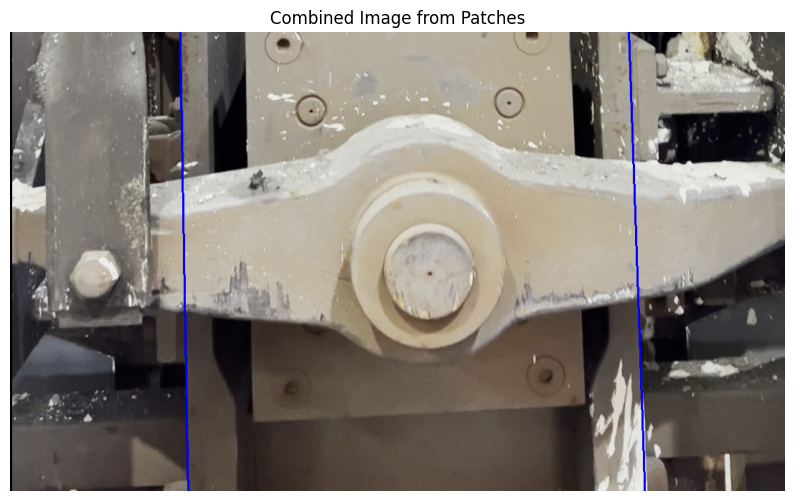

In [445]:
plt.figure(figsize=(10, 10))
plt.imshow(line_img)
plt.title("Combined Image from Patches")
plt.axis('off')
plt.show()

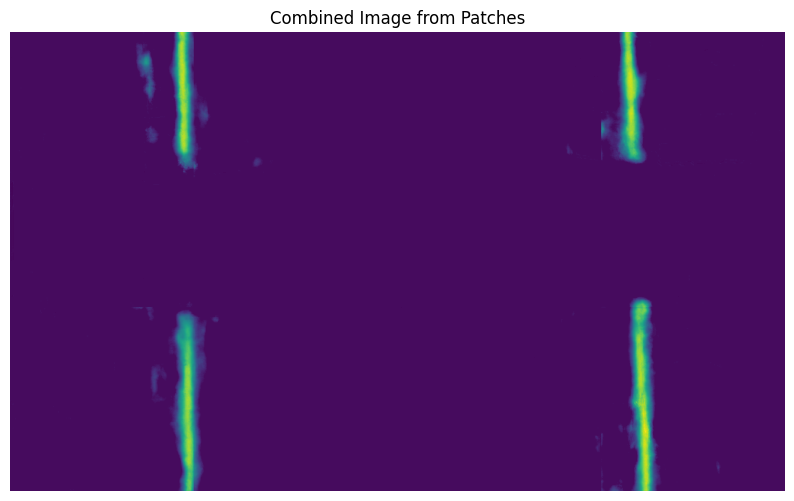

In [446]:
plt.figure(figsize=(10, 10))
plt.imshow(mask)
plt.title("Combined Image from Patches")
plt.axis('off')
plt.show()

In [456]:
import bentoml

In [457]:
metadata = {  
    'acc': 0.846,
    'dataset_version': '20240619',
}

signature = {'predict': {'batchable': False}}  # 호출되는 방법을 정의

In [458]:
saved_model = bentoml.pytorch.save_model(
    'GasDoor',
    gas_door,
    signatures=signature,
    metadata=metadata, 
)

print(saved_model)

Converting 'GasDoor' to lowercase: 'gasdoor'.


Model(tag="gasdoor:ey243pj2nwprtqb4")


In [153]:
image = torch.rand((640, 1080, 3))

# image_np = image_tensor.numpy()
# image_np = image_np.transpose(1, 2, 0)
# image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
# image_tensor.shape, image_np.shape, image_pil.size

In [154]:
if image.is_cuda:
    image = image.cpu().detach().numpy()
else:
    image = image.detach().numpy()
#image = image.transpose(2,0,1)
image = Image.fromarray(image.astype(np.uint8)) 
image.size, type(image)

((1080, 640), PIL.Image.Image)

In [155]:
cell = image.copy()
i, j = 0,0
h, w = 288, 288
cell = pad(cell, 16, padding_mode='reflect')
cell = crop(cell, i, j, h, w)
cell = to_tensor(cell)  
cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])